In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Online feature serving and fetching of BigQuery data with Vertex AI Feature Store


<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/feature_store/online_feature_serving_and_fetching_bigquery_data_with_feature_store_bigtable.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fvertex-ai-samples%2Fmain%2Fnotebooks%2Fofficial%2Ffeature_store%2Fonline_feature_serving_and_fetching_bigquery_data_with_feature_store_bigtable.ipynb">
      <img width="32px" src="https://cloud.google.com/ml-engine/images/colab-enterprise-logo-32px.png" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/feature_store/online_feature_serving_and_fetching_bigquery_data_with_feature_store_bigtable.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/feature_store/online_feature_serving_and_fetching_bigquery_data_with_feature_store_bigtable.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>


## Overview

This tutorial demonstrates how to use Vertex AI Feature Store for online serving and fetching of feature values in BigQuery.

Learn more about [Vertex AI Feature Store](https://cloud.google.com/vertex-ai/docs/featurestore/overview).

### Objective

In this tutorial, you learn how to create and use an online feature store instance to host and serve data in BigQuery with Vertex AI Feature Store in an end to end workflow of feature values serving and fetching user journey.

This tutorial uses the following Google Cloud ML services and resources:

- Vertex AI Feature Store

The steps performed include:

- Provision an online feature store instance to host and serve data.
- Register a BigQuery view with the online feature store instance and set up the sync job.
- Use the online server to fetch feature values for online prediction.

### Dataset

This tutorial uses the [theLook_eCommerce](https://console.cloud.google.com/marketplace/product/bigquery-public-data/thelook-ecommerce) dataset from the BigQuery public datasets.

The Look eCommerce has developed a sales prediction model for their merchandise. The model uses the following data:

* Product name
* Category
* Brand
* Cost
* Retail price
* Number of orders over the past 30 days, classified as good or bad based on status


### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* BigQuery

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and
[BigQuery pricing](https://cloud.google.com/bigquery/pricing)
and use the [Pricing Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Get started

### Install Vertex AI SDK for Python and other required packages


In [ ]:
! pip3 install --upgrade --quiet google-cloud-aiplatform\
                                 google-cloud-bigquery\
                                 db-dtypes

### Restart runtime (Colab only)

To use the newly installed packages, you must restart the runtime on Google Colab.

In [ ]:
import sys

if "google.colab" in sys.modules:

    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Wait until it's finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

Authenticate your environment on Google Colab.


In [ ]:
import sys

if "google.colab" in sys.modules:

    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK for Python

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com). Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [ ]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}


from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=LOCATION)
API_ENDPOINT = f"{LOCATION}-aiplatform.googleapis.com"

### Import libraries

In [ ]:
from google.cloud import bigquery
from google.cloud.aiplatform_v1 import (FeatureOnlineStoreAdminServiceClient,
                                        FeatureOnlineStoreServiceClient,
                                        FeatureRegistryServiceClient)
from google.cloud.aiplatform_v1.types import feature as feature_pb2
from google.cloud.aiplatform_v1.types import feature_group as feature_group_pb2
from google.cloud.aiplatform_v1.types import \
    feature_online_store as feature_online_store_pb2
from google.cloud.aiplatform_v1.types import \
    feature_online_store_admin_service as \
    feature_online_store_admin_service_pb2
from google.cloud.aiplatform_v1.types import \
    feature_online_store_service as feature_online_store_service_pb2
from google.cloud.aiplatform_v1.types import \
    feature_registry_service as feature_registry_service_pb2
from google.cloud.aiplatform_v1.types import feature_view as feature_view_pb2
from google.cloud.aiplatform_v1.types import \
    featurestore_service as featurestore_service_pb2
from google.cloud.aiplatform_v1.types import io as io_pb2

## Set up feature data in BigQuery

In this tutorial, you want to recompute and update this data on a daily basis to provide real-time predictions, so that the online prediction application always uses the latest data.

Retrieve the number of orders as of the current time and join the retrieved data with the `bigquery-public-data.thelook_ecommerce.products` table:

In [ ]:
feature_extract_query = """
WITH
 product_order_agg AS (
   SELECT cast(product_id as string) as entity_id,
     countif(status in ("Shipped", "Complete")) as good_order_count,
     countif(status in ("Returned", "Cancelled")) as bad_order_count
   FROM `bigquery-public-data.thelook_ecommerce.order_items`
   WHERE
     timestamp_trunc(created_at, day) >= timestamp_trunc(timestamp_sub(CURRENT_TIMESTAMP(), interval 30 day), day) and
     timestamp_trunc(created_at, day) < timestamp_trunc(CURRENT_TIMESTAMP(), day)
   group by 1
   order by entity_id),
 product_basic AS (
   SELECT cast(id as string) AS entity_id,
     lower(name) as name,
     lower(category) as category,
     lower(brand) as brand,
     cost,
     retail_price
   FROM   bigquery-public-data.thelook_ecommerce.products)
SELECT *, current_timestamp() as feature_timestamp
FROM product_basic
LEFT OUTER JOIN product_order_agg
USING (entity_id)
"""

#### View the retrieved data

In [ ]:
bq_client = bigquery.Client(project=PROJECT_ID)

product_data = bq_client.query(feature_extract_query).result().to_dataframe()

print(product_data.shape)
product_data.head()

Now that the data is joined with the BigQuery table, you're ready to set up online serving. You have two options:

* Materialize the data into a dedicated table.
* Create a BigQuery view that regenerates every time it's queried.

This tutorial demonstrates the latter option, that is, how to create a BigQuery view that regenerates with each query.


## Create BigQuery dataset

Create a BigQuery dataset to hold the BigQuery view for the demo. Since the source data for this demo is located in the `US` region, the dataset must also be located in the `US` region. If you use your own data and dataset, you can also use that dataset to create the BigQuery view.


In [ ]:
# First, create a dataset if it doesn't already exist. The source data for this demo is located in the US region, so the dataset must also be located in the US region.

BQ_DATASET_ID = "featurestore_demo"  # @param {type:"string"}
dataset = bigquery.Dataset(f"{PROJECT_ID}.{BQ_DATASET_ID}")
dataset.location = "US"
dataset = bq_client.create_dataset(
    dataset, exists_ok=True, timeout=30
)  # Make an API request.
# Confirm dataset created.
print(f"Created dataset {dataset}.{BQ_DATASET_ID}")

#### Create a BigQuery view

In [ ]:
# Now, create the view

BQ_VIEW_ID = "product_features"  # @param {type:"string"}
BQ_VIEW_ID_FQN = f"{PROJECT_ID}.{BQ_DATASET_ID}.{BQ_VIEW_ID}"
view = bigquery.Table(BQ_VIEW_ID_FQN)
view.view_query = feature_extract_query
view = bq_client.create_table(view, exists_ok=True)

print(f"Created {view.table_type}: {str(view.reference)}")

## Set up and start online serving

Now for the exciting part! To serve data in a feature store, you need to do the following:

1. Create an online store cluster to host the data.
    * Create a `FeatureOnlineStore` instance with autoscaling.
1. Define the data (`FeatureView`) to be served by the newly-created instance. This can either map to
    * The BigQuery view that you just created for serving data.
    * The `FeatureGroup` and `Feature` you'll create to host feature metadata.

Bigtable serving latency is affected by the (Bigtable) load. However, when Bigtable is not overloaded, benchmarks show that the expected server-side latency is around 30 ms, measured at around 100 qps. The client-side latency is expected to be more than 5 ms higher than the server-side latency.

### Initialize Admin Service Client


In [ ]:
admin_client = FeatureOnlineStoreAdminServiceClient(
    client_options={"api_endpoint": API_ENDPOINT}
)
registry_client = FeatureRegistryServiceClient(
    client_options={"api_endpoint": API_ENDPOINT}
)

### Create online store instance

To create an online store instance.
Create a `FeatureOnlineStore` instance with autoscaling.

In [ ]:
FEATURE_ONLINE_STORE_ID = "the_look_demo_unique"  # @param {type:"string"}

online_store_config = feature_online_store_pb2.FeatureOnlineStore(
    bigtable=feature_online_store_pb2.FeatureOnlineStore.Bigtable(
        auto_scaling=feature_online_store_pb2.FeatureOnlineStore.Bigtable.AutoScaling(
            min_node_count=1, max_node_count=3, cpu_utilization_target=50
        )
    )
)

create_store_lro = admin_client.create_feature_online_store(
    feature_online_store_admin_service_pb2.CreateFeatureOnlineStoreRequest(
        parent=f"projects/{PROJECT_ID}/locations/{LOCATION}",
        feature_online_store_id=FEATURE_ONLINE_STORE_ID,
        feature_online_store=online_store_config,
    )
)

### Verify online store instance creation

After the long-running operation (LRO) is complete, show the result.

> **Note:** This operation might take up to 10 minutes to complete.

In [ ]:
# Wait for the LRO to finish and get the LRO result.
print(create_store_lro.result())

Verify that the `FeatureOnlineStore` instance is created by listing all online stores for the location.

In [ ]:
# Use list to verify the store is created.
admin_client.list_feature_online_stores(
    parent=f"projects/{PROJECT_ID}/locations/{LOCATION}"
)

### Create feature view instance

After creating a `FeatureOnlineStore` instance, you can define the features to serve with it. To do this, create a `FeatureView` instance, which specifies the following:

* A data source (BigQuery table or view URI or FeatureGroup/features ) synced to the `FeatureOnlineStore` instance for serving.
* The cron schedule to run the sync pipeline.


#### Option 1: Create featureView directly with BQ source

##### Data source preparation guidelines for BigQuery data source

If the feature data for online serving isn't already available in a BigQuery table or view, you can create a BigQuery dataset and table, and then load the data into it.

Note that if you choose to use BigQuery source, Feature Store only provides the option to snapshot and sync the entire BigQuery table or view for online serving. You need to construct this table or view to reflect the latest data to be served. Therefore, a timestamp column is not needed, since timestamps aren't used to differentiate the feature values.

Use the following guidelines to understand the schema and constraints while creating the BigQuery source:

* The BigQuery table or view *must* have a column with `string` values to use as the (entity) IDs. You'll need to specify that this column is the ID column during `FeatureView` creation. Note that the size of each value in this column must be less than 4 KB.
* Feature Store ignores rows containing the duplicate values in the ID column and arbitrarily picks one to use for online serving. This might occur if the table or view has multiple feature values recorded at different timestamps. In this case, you need to sync the data in your table based on the latest timestamp before serving.
* Feature Store considers each row as a complete record. For example, if a feature value is missing in one of the columns, then it's considered as a null value.
* Provide values for each feature is a separate column. Supported data types are `bool`, `int`, `double`, `string`, timestamp, arrays of these data types, and bytes. Note that the timestamp data type is converted to `int64` during data sync.
* Feature Store validates the schema during `FeatureView` creation. However, it doesn't revalidate the schema during each data sync. Columns with unsupported data types added after `FeatureView` creation time are ignored.
* The BigQuery table or view must be in either the same region as the online store, or in a multiregion that overlaps with the online store. For example, if the online store is in `us-central`, the BigQuery source can be in `us-central` or in `US`.

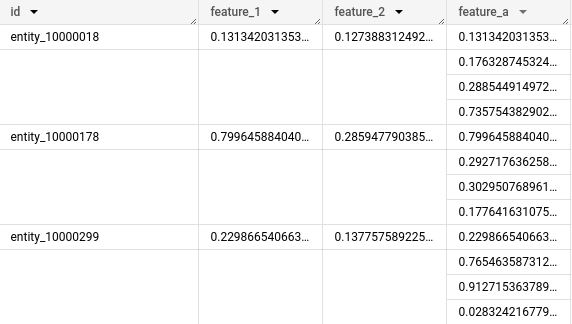


In [ ]:
FEATURE_VIEW_ID = "product"  # @param {type:"string"}
CRON_SCHEDULE = "TZ=America/Los_Angeles 56 * * * *"  # @param {type:"string"}

big_query_source = feature_view_pb2.FeatureView.BigQuerySource(
    uri=f"bq://{BQ_VIEW_ID_FQN}", entity_id_columns=["entity_id"]
)

sync_config = feature_view_pb2.FeatureView.SyncConfig(cron=CRON_SCHEDULE)

create_view_lro = admin_client.create_feature_view(
    feature_online_store_admin_service_pb2.CreateFeatureViewRequest(
        parent=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}",
        feature_view_id=FEATURE_VIEW_ID,
        feature_view=feature_view_pb2.FeatureView(
            big_query_source=big_query_source,
            sync_config=sync_config,
        ),
    )
)

# Wait for LRO to complete and show result
print(create_view_lro.result())

#### Option 2: Create featureView with FeatureGroups/Feature

> **Note:** If you've already created a feature view with BQ source, skip this section and go to [Verify online store instance creation](#scrollTo=igOmzHxx1C0X).

#### [Optional] Create FeatureGroup/Features

Create a FeatureGroup pointing to the created BigQuery view for the demo. You then create features for each column you'd like to register.


##### Data source preparation guidelines for Feature Registry data source

Note that if you choose to use Feature Registry source, Feature Store only provides the option to support time-series sources for which Feature Store generates latest featureValues.

Use the following guidelines to understand the schema and constraints while creating the BigQuery source:

* The BigQuery table or view *must* have a column with `string` values to use as the (entity) IDs. You'll need to specify that this column is the ID column during `FeatureGroup` creation. Note that the size of each value in this column must be less than 4 KB.
* The BigQuery table or view *must* have a column named `feature_timestamp` with `timestamp` values to use as timestamp column.
* Feature Registry sources are treated as sparse by default i.e. a point in time lookup (BQ.ML_FEATURES_AT_TIME()) to generate latest featureValues per entityId.
* Provide values for each feature is a separate column. Supported data types are `bool`, `int`, `double`, `string`, timestamp, arrays of these data types, and bytes. Note that the timestamp data type is converted to `int64` during data sync.
* Feature Store validates the schema during `FeatureView`/`FeatureGroup`/`Featre` creation. However, it doesn't revalidate the schema during each data sync. Columns with unsupported data types added after `FeatureView` creation time are ignored.
* The BigQuery table or view must be in either the same region as the online store, or in a multiregion that overlaps with the online store. For example, if the online store is in `us-central`, the BigQuery source can be in `us-central` or in `US`.

In [ ]:
FEATURE_GROUP_ID = "product_features_unique"  # @param {type: "string"}
FEATURE_IDS = [
    "good_order_count",
    "bad_order_count",
    "category",
    "name",
    "brand",
    "cost",
    "retail_price",
]  # @param

In [ ]:
# Now, create the featureGroup

feature_group_config = feature_group_pb2.FeatureGroup(
    big_query=feature_group_pb2.FeatureGroup.BigQuery(
        big_query_source=io_pb2.BigQuerySource(input_uri=f"bq://{BQ_VIEW_ID_FQN}")
    )
)

create_group_lro = registry_client.create_feature_group(
    feature_registry_service_pb2.CreateFeatureGroupRequest(
        parent=f"projects/{PROJECT_ID}/locations/{LOCATION}",
        feature_group_id=FEATURE_GROUP_ID,
        feature_group=feature_group_config,
    )
)

After the long-running operation (LRO) is complete, show the result.

In [ ]:
print(create_group_lro.result())

In [ ]:
create_feature_lros = []
for id in FEATURE_IDS:
    create_feature_lros.append(
        registry_client.create_feature(
            featurestore_service_pb2.CreateFeatureRequest(
                parent=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureGroups/{FEATURE_GROUP_ID}",
                feature_id=id,
                feature=feature_pb2.Feature(),
            )
        )
    )

In [ ]:
for lro in create_feature_lros:
    print(lro.result())

Create a `FeatureView` instance for the BigQuery view and FeatureGroup/features you created earlier in this tutorial and set the sync time and frequency to 1:00 AM PST daily.

In [ ]:
FEATURE_VIEW_ID = "registry_product"  # @param {type:"string"}
CRON_SCHEDULE = "TZ=America/Los_Angeles 56 * * * *"  # @param {type:"string"}

feature_registry_source = feature_view_pb2.FeatureView.FeatureRegistrySource(
    feature_groups=[
        feature_view_pb2.FeatureView.FeatureRegistrySource.FeatureGroup(
            feature_group_id=FEATURE_GROUP_ID, feature_ids=FEATURE_IDS
        )
    ]
)

sync_config = feature_view_pb2.FeatureView.SyncConfig(cron=CRON_SCHEDULE)

create_view_lro = admin_client.create_feature_view(
    feature_online_store_admin_service_pb2.CreateFeatureViewRequest(
        parent=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}",
        feature_view_id=FEATURE_VIEW_ID,
        feature_view=feature_view_pb2.FeatureView(
            feature_registry_source=feature_registry_source,
            sync_config=sync_config,
        ),
    )
)

# Wait for LRO to complete and show result
print(create_view_lro.result())

Verify that the `FeatureView` instance is created by listing all the feature views within the online store.

In [ ]:
# Again, list all feature view under the FEATURE_ONLINE_STORE_ID to confirm
admin_client.list_feature_views(
    parent=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}"
)

###Note
Syncing data into FeatureOnlineStores is a public Preview release. By using the feature, you acknowledge that you're aware of the open issues and that this preview is provided “as is” under the pre-GA terms of service.


### Start sync manually

The sync pipeline executes according to the schedule specified in the `FeatureView` instance.

To skip the wait and execute the sync pipeline immediately, start the sync manually.

In [ ]:
sync_response = admin_client.sync_feature_view(
    feature_view=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}/featureViews/{FEATURE_VIEW_ID}"
)

The `sync_response` contains the ID of the sync job.

Use `get_feature_view_sync` to check the status of the job.

In [ ]:
import time

while True:
    feature_view_sync = admin_client.get_feature_view_sync(
        name=sync_response.feature_view_sync
    )
    if feature_view_sync.run_time.end_time.seconds > 0:
        status = "Succeed" if feature_view_sync.final_status.code == 0 else "Failed"
        print(f"Sync {status} for {feature_view_sync.name}.")
        break
    else:
        print("Sync ongoing, waiting for 30 seconds.")
    time.sleep(30)

Use `list_feature_view_syncs` to view all your syncs.

In [ ]:
admin_client.list_feature_view_syncs(
    parent=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}/featureViews/{FEATURE_VIEW_ID}"
)

### Start online serving

After the data sync is complete, use the `FetchFeatureValues` API to retrieve the data.

In [ ]:
data_client = FeatureOnlineStoreServiceClient(
    client_options={"api_endpoint": API_ENDPOINT}
)

The `FeatureView` already defines the features needed for the model (via the BigQuery view in this demo). To fetch the data, submit a `fetch_feature_values` request specifying the `FeatureView` resource path and the ID of the entity.

In [ ]:
data_client.fetch_feature_values(
    request=feature_online_store_service_pb2.FetchFeatureValuesRequest(
        feature_view=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}/featureViews/{FEATURE_VIEW_ID}",
        data_key=feature_online_store_service_pb2.FeatureViewDataKey(key="28098"),
    )
)

You can specify the response format using `FetchFeatureValuesRequest.Format`. If you don't specify a format, then the format is set to `KEY_VALUE`, by default. `PROTO_STRUCT` is another supported format.

In [ ]:
data_client.fetch_feature_values(
    request=feature_online_store_service_pb2.FetchFeatureValuesRequest(
        feature_view=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}/featureViews/{FEATURE_VIEW_ID}",
        data_key=feature_online_store_service_pb2.FeatureViewDataKey(key="28098"),
        data_format=feature_online_store_service_pb2.FeatureViewDataFormat.PROTO_STRUCT,
    )
)

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial.

In [ ]:
# Delete Features
for id in FEATURE_IDS:
    registry_client.delete_feature(
        name=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureGroups/{FEATURE_GROUP_ID}/features/{id}"
    )

# Delete Featuregroup
registry_client.delete_feature_group(
    name=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureGroups/{FEATURE_GROUP_ID}"
)

# Delete FeatureViews
admin_client.delete_feature_view(
    name=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}/featureViews/{FEATURE_VIEW_ID}"
)

# Delete OnlineStore
admin_client.delete_feature_online_store(
    name=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}",
    force=True,
)

# Delete BigQuery dataset. Uncomment and run the command below if you want to delete the BigQuery set.
# Do this only if the dataset is created for this demo.
# bq_client.delete_dataset(BQ_DATASET_ID, delete_contents=True, not_found_ok=True)